---
format: 
  html:
    toc: true
    number-sections: true
    code-fold: true
execute:
  echo: true
---

# Use 2024 Predictions for DSNY Trash Collection Optimization

In this section, we use the 2024 predicted sanitation complaints counts to help DSNY develop its trash collection strategy for 2024, aiming to maximize collection efficiency.

Additionally, since we standardized the predictors during the Poisson Regression model construction in Section 4, the predicted values represent relative counts rather than absolute complaint numbers.

We aggregate the predicted complaint counts at different temporal and spatial scales to uncover patterns:

- First, we analyze the average predicted complaint counts across all DSNY units for each day of the week. The analysis shows that there is no significant variation between days, with Thursday having the highest number of complaints.
- Next, we calculate the average daily complaint counts for each DSNY unit over the course of the year. We observe considerable differences in complaint numbers across units, from which we identify the top ten units with the highest complaint counts and map their distribution.
- Finally, we cross-analyze the complaint distribution for each DSNY unit across different days of the week. This reveals that the variation within each unit throughout the week is small, while the differences between units are more pronounced.

We identify the three days with the highest relative complaint numbers for each DSNY unit as a reference for DSNY's trash collection schedule. We also create a spatial coverage map for each day of the week, showing the areas that need to be covered. This can be used to make flexible adjustments to collection routes or schedules to maximize collection efficiency.

Special attention should be given to the DSNY units with the highest predicted complaint numbers, where increasing collection frequency or days might be considered. Furthermore, additional predictors could be incorporated to further improve the model’s forecasting performance.

## Set Up

In [1]:
import pandas as pd
import geopandas as gpd
import numpy as np

import matplotlib.pyplot as plt
import hvplot.pandas
import seaborn as sns

## Load Prediction Results for 2024

Here, we loaded the model prediction results from Section 4 - the daily sanitation complaint counts for each DSNY unit in 2024 - as the foundation for subsequent analyses.

In [2]:
# Load the predicted results for 2024
predicted_results_2024 = pd.read_parquet('data/predicted_results_2024.parquet')

## Average Sanitation Complaints by Day of Week

We analyzed the average daily sanitation complaint counts across all DSNY units for each day of the week. The results show that the differences between days are not significant, and there is no notable distinction between weekends and weekdays. However, Thursday stands out with relatively higher predicted complaint counts.

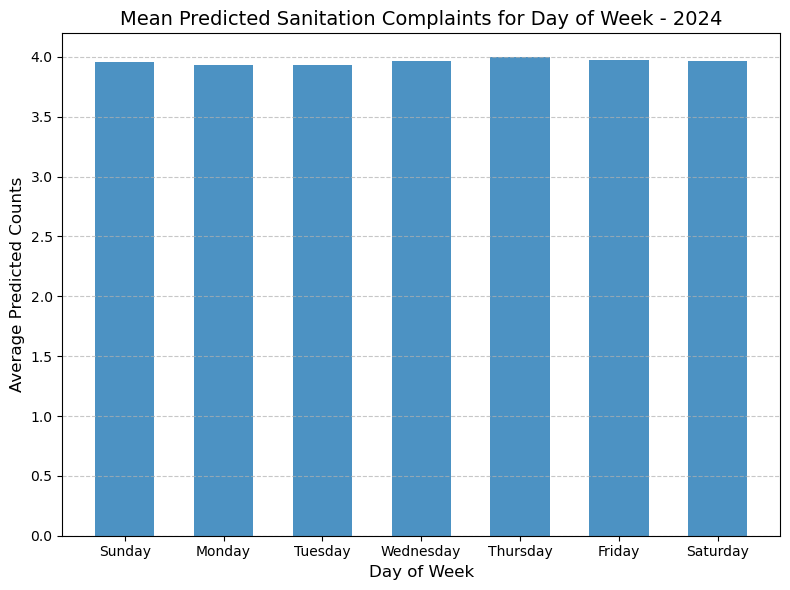

In [3]:
# Set the order of Day of Week
day_order = ["Sunday", "Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday"]
predicted_results_2024["Day of Week"] = pd.Categorical(
    predicted_results_2024["Day of Week"], 
    categories=day_order, 
    ordered=True
)

# Recalculate the average values
average_predicted_dow = (
    predicted_results_2024.groupby("Day of Week")["Predicted"].mean().reset_index()
)

# Plot
plt.figure(figsize=(8, 6))
plt.bar(
    average_predicted_dow["Day of Week"], 
    average_predicted_dow["Predicted"] * 10, 
    width=0.6, 
    alpha=0.8
)

plt.title("Mean Predicted Sanitation Complaints for Day of Week - 2024", fontsize=14)
plt.xlabel("Day of Week", fontsize=12)
plt.ylabel("Average Predicted Counts", fontsize=12)

plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

## Average Sanitation Complaints by DSNY Units

We calculated the average daily sanitation complaint counts for each DSNY unit over the course of the year and identified the top ten areas with the highest predicted counts as key focus points. Additionally, we created a distribution map of the predicted values across the entire region. The map reveals that areas with higher predicted counts are primarily concentrated in the southern part of Manhattan Island and its surrounding areas.

In [4]:
# Group the predicted results by DSNY_ID
average_predicted_unit = (
    predicted_results_2024.groupby("DSNY_ID")["Predicted"].mean().reset_index()
)

average_predicted_unit_sorted = average_predicted_unit.sort_values(
    by="Predicted", ascending=False
).reset_index(drop=True)

average_predicted_unit_sorted.head(n=10)

,DSNY_ID,Predicted
0,BKN012_B,1.750697
1,SI037_C,1.688011
2,BKS074_E,1.654605
3,MN043_B,1.650606
4,MN022_A,1.475389
5,BX062_A,1.416731
6,BKN032_A,1.385093
7,BX031_A,1.362096
8,BKN012_A,1.360927
9,BKN051_C,1.325811


In [5]:
# Import the DSNY boundary data
DSNY_boundary = gpd.read_file("data/1_DSNY_boundary_processed.geojson")
DSNY_boundary = DSNY_boundary.to_crs(epsg=2263)

# Merge the DSNY boundary data with the average predicted unit data
average_predicted_unit_boundary = DSNY_boundary.merge(
    average_predicted_unit,
    on="DSNY_ID",
    how="inner"
)

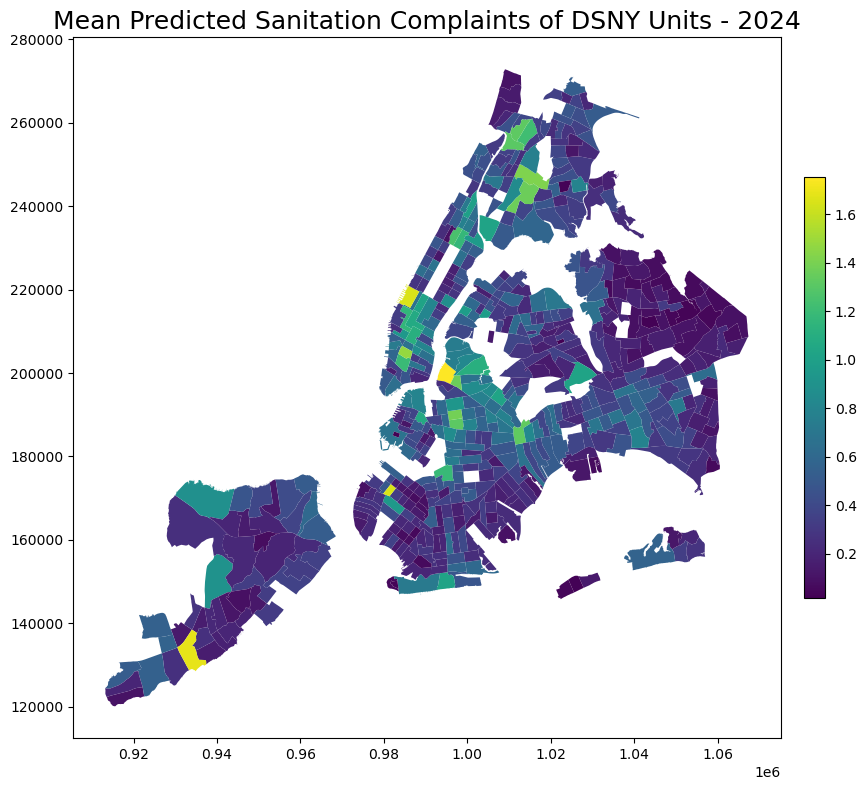

In [6]:
# Create a single plot
fig, ax = plt.subplots(figsize=(12, 8))

# Plot the map based on Predicted column
average_predicted_unit_boundary.plot(
    column='Predicted',
    cmap="viridis",
    legend=True,
    ax=ax,
    legend_kwds={
        'shrink': 0.6,
        'location': 'right',
        'pad': 0.02,
        'aspect': 20
    }
)

# Set the title
ax.set_title("Mean Predicted Sanitation Complaints of DSNY Units - 2024", fontsize=18)

# Adjust layout and show the plot
plt.tight_layout()
plt.show()

## Average Sanitation Complaints by DSNY Units and Day of Week

### Heatmap of Sanitation Complaints for DSNY Units by Day of Week

This heatmap presents a cross-analysis of sanitation complaint counts across different DSNY units and days of the week. It shows that the variation in complaint counts across different days within the same unit is not significant, whereas the differences between units are comparatively more pronounced.

/var/folders/4s/r9g1pcw12mv6gt8hx2lkth3h0000gn/T/ipykernel_5374/4086100161.py:9: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  pivot_table = average_predicted_dow_unit.pivot("DSNY_ID", "Day of Week", "Predicted")


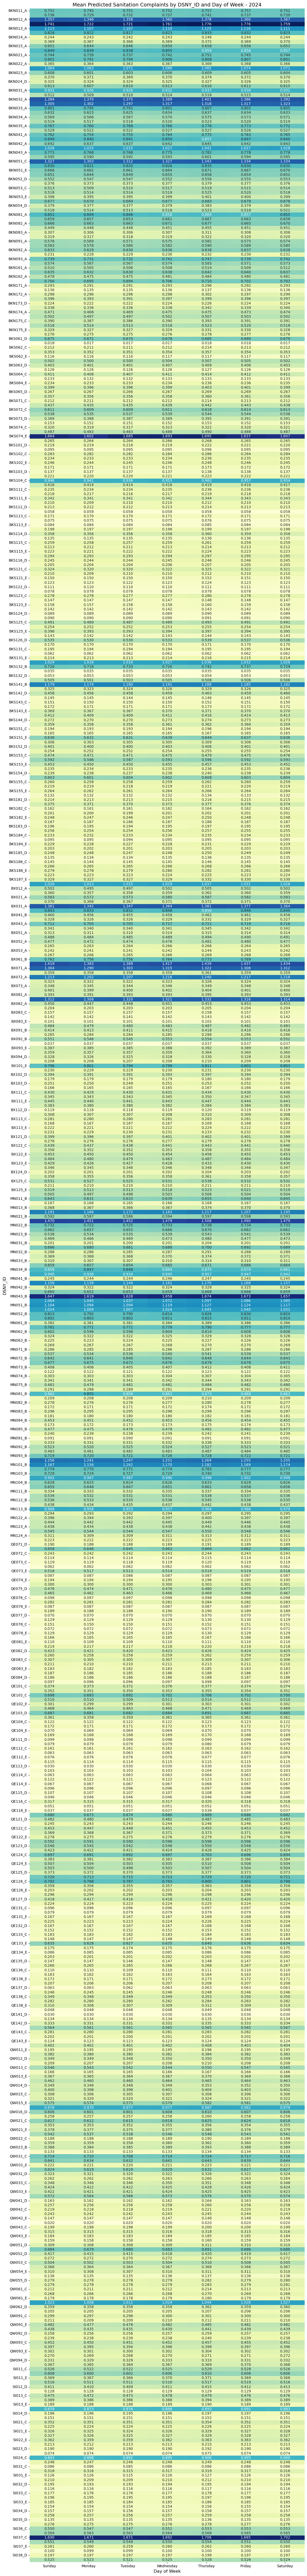

In [7]:
# Group the predicted results by DSNY_ID and day of week
average_predicted_dow_unit = (
    predicted_results_2024.groupby(["DSNY_ID", "Day of Week"])["Predicted"]
    .mean()
    .reset_index()
)

# Create a pivot table for the average predicted counts by DSNY_ID and day of week
pivot_table = average_predicted_dow_unit.pivot("DSNY_ID", "Day of Week", "Predicted")

# Plot the pivot table as a heatmap
plt.figure(figsize=(12, 100))  # Adjust the figure height to show all DSNY_IDs
sns.heatmap(
    pivot_table, 
    annot=True, 
    fmt=".3f",  # Maintain 3 decimal places
    cmap="YlGnBu", 
    cbar=False  # Remove the color bar
)

plt.title("Mean Predicted Sanitation Complaints by DSNY_ID and Day of Week - 2024", fontsize=14)
plt.xlabel("Day of Week", fontsize=12)
plt.ylabel("DSNY_ID", fontsize=12)
plt.tight_layout()
plt.show()

### Map of the Top Three Days for Sanitation Complaints by DSNY Units

Based on DSNY's current trash collection strategy, we ranked the sanitation complaint counts for each DSNY unit across the days of the week and identified the top three days with the highest counts as the recommended trash collection days for each unit. The analysis shows that most units have the highest complaint counts on Thursdays, while the second and third highest days are more scattered, making it difficult to identify a clear pattern. Therefore, further analysis is conducted in the next step.

In [8]:
# Find the top three days of the week for each DSNY_ID
top_three_days = (
    average_predicted_dow_unit.sort_values(by=["DSNY_ID", "Predicted"], ascending=[True, False])
    .groupby("DSNY_ID")
    .head(3)
)

# Top three cleaning days per DSNY_ID
clean_day_result = (
    top_three_days.assign(rank=top_three_days.groupby("DSNY_ID").cumcount() + 1)
    .pivot(index="DSNY_ID", columns="rank", values="Day of Week")
    .reset_index()
)

clean_day_result.columns = ["DSNY_ID", "Top Day 1", "Top Day 2", "Top Day 3"]

# Merge with DSNY boundaries
clean_day_result = DSNY_boundary.merge(
    clean_day_result,
    on="DSNY_ID",
    how="inner"
)

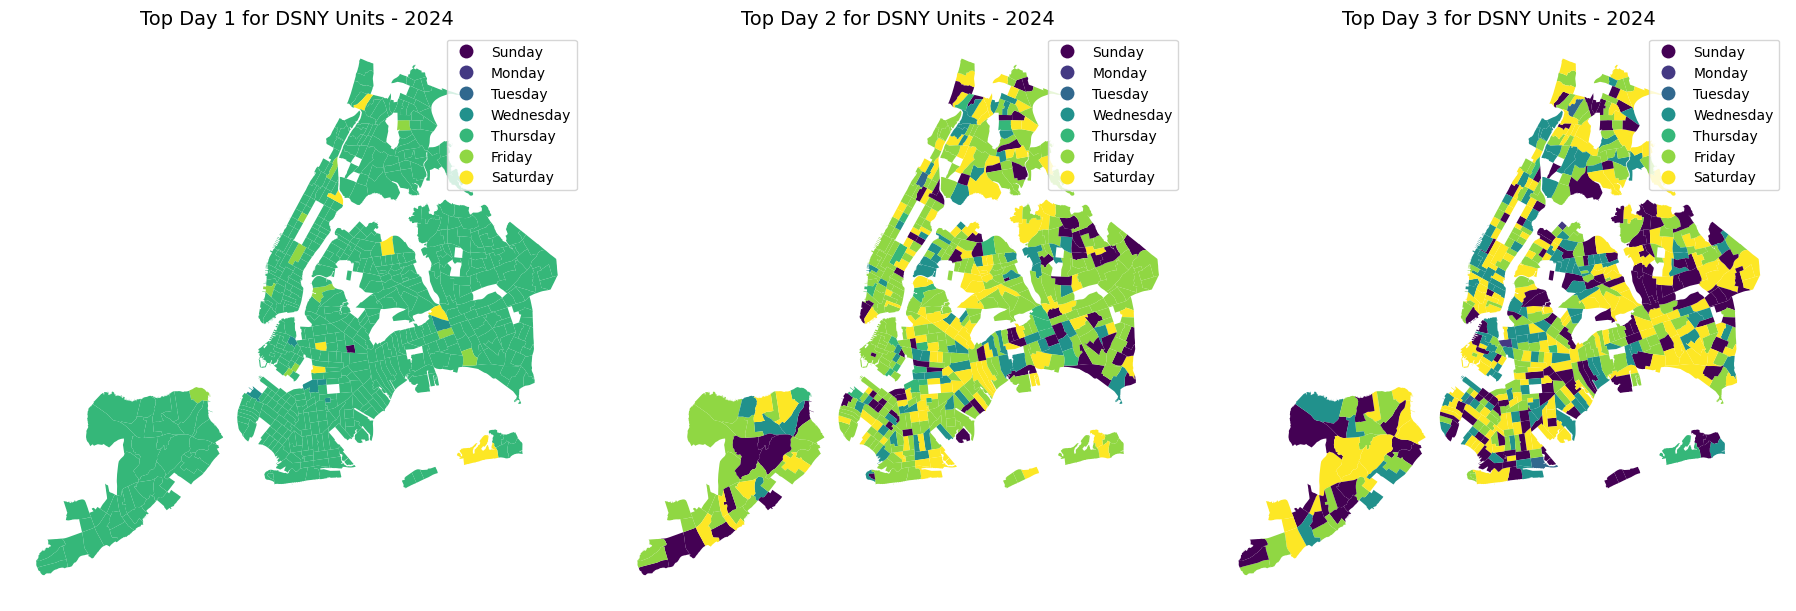

In [9]:
# List of columns to plot
top_days = ["Top Day 1", "Top Day 2", "Top Day 3"]

# Set up the grid for subplots (1 row, 3 columns)
fig, axes = plt.subplots(1, 3, figsize=(18, 6), constrained_layout=True)

# Iterate through each column and plot
for i, col in enumerate(top_days):
    clean_day_result.plot(
        column=col,
        cmap="viridis",
        legend=True,
        ax=axes[i]
    )
    # Set the title for each subplot
    axes[i].set_title(f"{col} for DSNY Units - 2024", fontsize=14)
    axes[i].axis("off")  # Remove axes for cleaner visualization

# Show the plot
plt.show()

### Map of Cleaning Demand Areas for Each Day of the Week by DSNY Units

In this step, we created distribution maps based on the top three days with the highest sanitation complaint counts for each DSNY unit, with each map corresponding to a specific day of the week. In the maps, pink areas represent DSNY units that require trash collection on that particular day.

These maps provide a clear visualization of the locations needing trash collection each day. By integrating other factors, DSNY can flexibly adjust spatial and temporal trash collection strategies, helping to optimize routes and schedules for maximum collection efficiency.

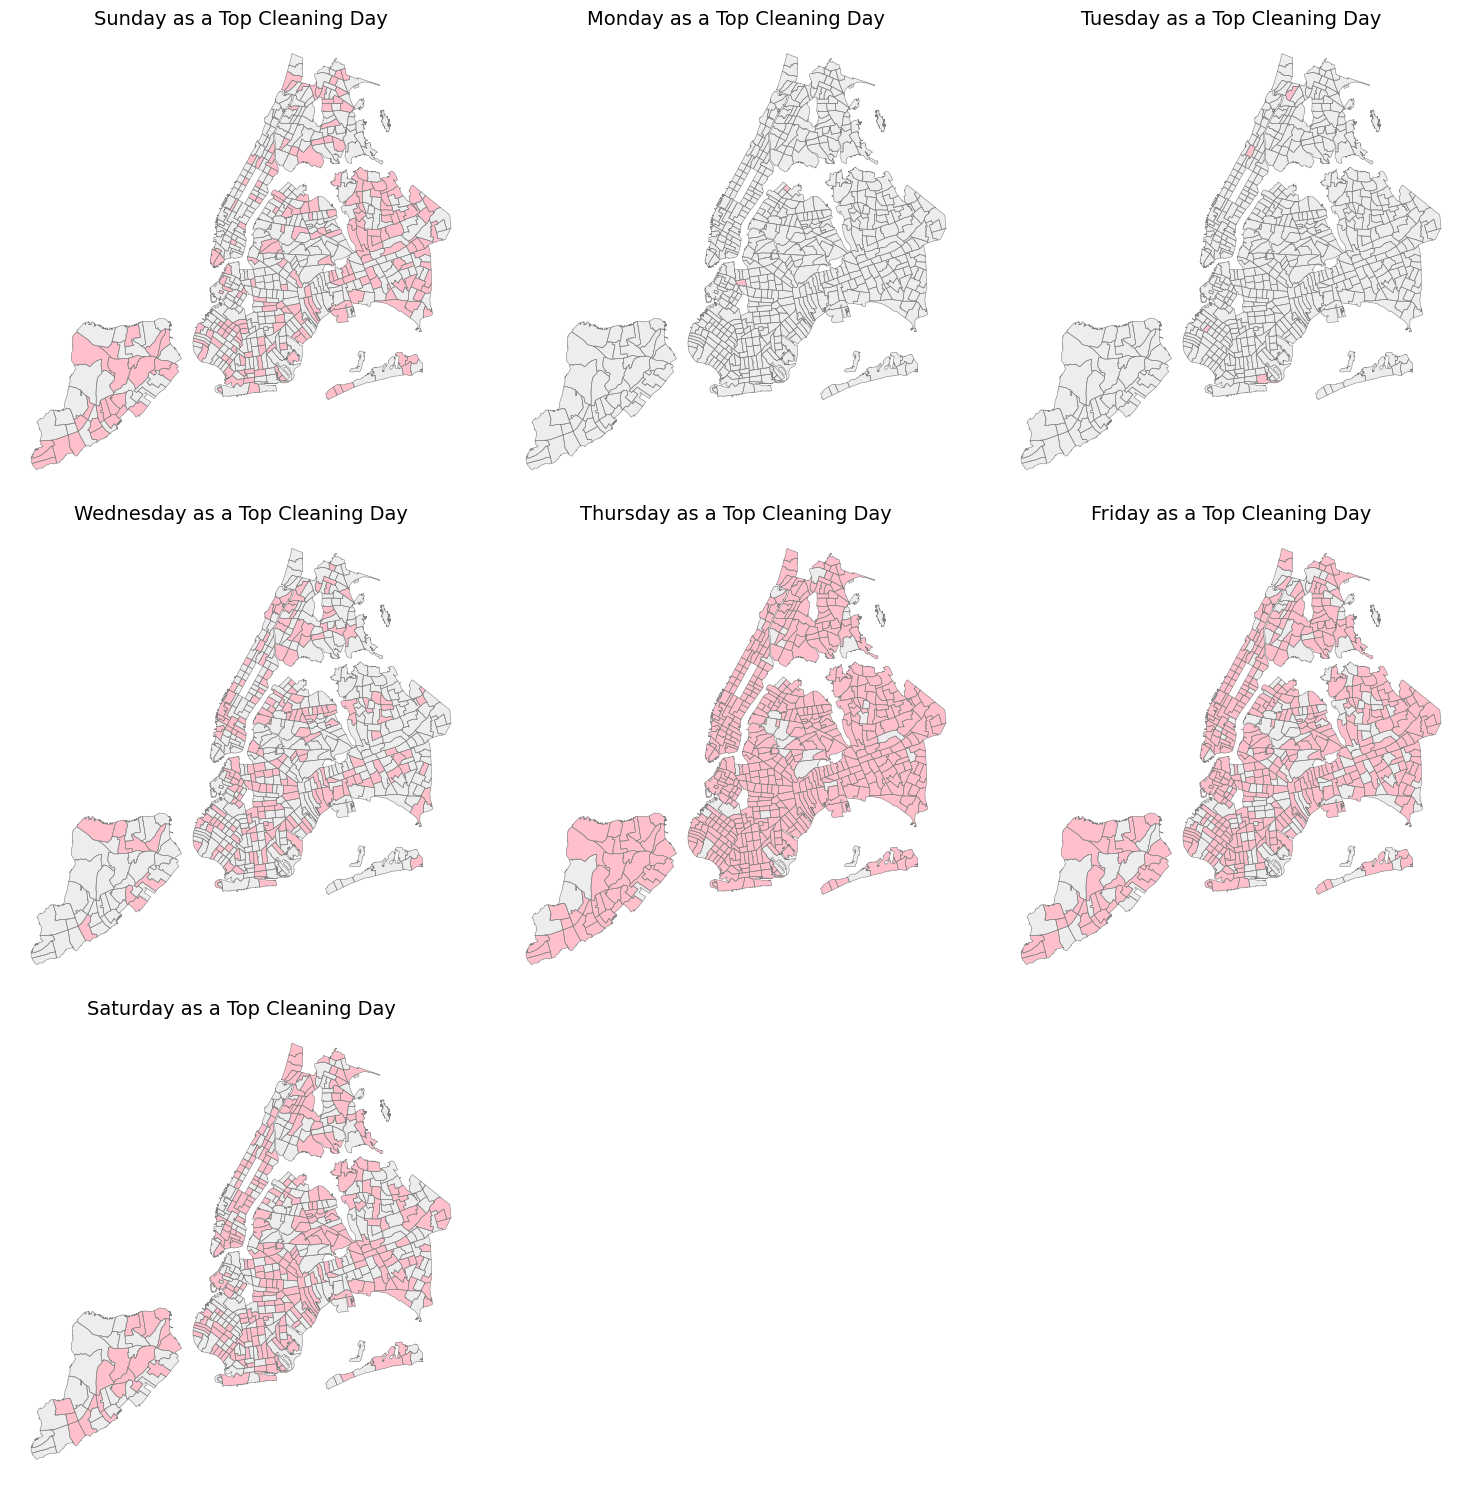

In [10]:
# List of all days of the week
days_of_week = ["Sunday", "Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday"]

# Set up the grid for subplots (3 columns, adjust rows automatically)
n_cols = 3
n_rows = (len(days_of_week) + n_cols - 1) // n_cols  # Calculate number of rows
fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, n_rows * 5))

# Flatten the axes for easy indexing
axes = axes.flatten()

# Iterate through each day and plot
for i, day in enumerate(days_of_week):
    # Filter the GeoDataFrame to include units with the current day in any of the top days
    filtered_df = clean_day_result[
        (clean_day_result["Top Day 1"] == day) |
        (clean_day_result["Top Day 2"] == day) |
        (clean_day_result["Top Day 3"] == day)
    ]

    # Create the plot on the respective subplot
    # Step 1: Plot fill colors
    DSNY_boundary.plot(
        ax=axes[i],
        color="lightgrey",  # Default fill color
        edgecolor="none",   # No edge for this layer
        alpha=0.4
    )

    filtered_df.plot(
        ax=axes[i],
        color="#FFC0CB",  # Highlight selected units with pink
        edgecolor="none"  # No edge for this layer
    )

    # Step 2: Plot boundary lines
    DSNY_boundary.boundary.plot(
        ax=axes[i],
        edgecolor="grey",  # Boundary line color
        linewidth=0.4       # Boundary line thickness
    )

    # Set title for the subplot
    axes[i].set_title(f"{day} as a Top Cleaning Day", fontsize=14)
    axes[i].axis("off")  # Remove axes

# Turn off unused axes if any
for j in range(len(days_of_week), len(axes)):
    axes[j].axis("off")

# Adjust layout
plt.tight_layout()
plt.show()